Load standard python libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import cluster, spatial
import skimage as ski
from skimage import feature, io
import sys
import matplotlib.pyplot as plt

The protoclust code can be installed from pip or built from source using Poetry (https://github.com/andgoldschmidt/pyprotoclust)

In [2]:
# Install from pip or build from source
from pyprotoclust import protoclust

# Preliminary

The first step is to download the project data from figshare at https://doi.org/10.6084/m9.figshare.c.5526474.

For this tutorial, we will need to download the following files:
- ImageData/Example.jpg
- CoordinatesTable/CoordinatesTable.csv
- DistancesTable/DistancesTable.csv

Set the variable `data_root` to the directory where you put the files.

In [3]:
# TODO: Set the root directory for the data
data_root = './playground/'

from os.path import join
coordinatesTablePath = join(data_root, 'CoordinatesTable.csv')
distancesTablePath = join(data_root, 'DistancesTable.csv')
examplePath = join(data_root, 'Example.jpg')

# Image pre-processing

*Example.jpg* is a picture of a yeast colony.

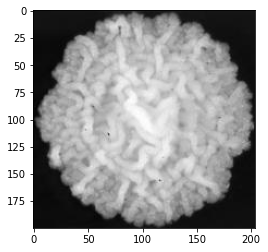

In [4]:
fig,ax = plt.subplots(1)
im = ski.io.imread(examplePath)
ax.imshow(im, cmap='binary_r')

Explore:
- Canny edge detection (*skimage.feature.canny*) determined the edges and boundaries of any objects in the image. This included the colony boundary.
- The circular Hough transform (*skimage.transform.hough\_circle\_peaks*) found the maximal radius of the largest (approximately) circular object in the Canny edge detection image. This was assumed to encompass the colony boundary. Anything outside this circle was masked. 
- A convex hull (*skimage.morphology.convex\_hull\_image*) was drawn around the unmasked region of the original image to capture the true (non-circular) colony boundary in detail.

# Local binary patterns

We can compute the local binary pattern for *Example.jpg* using *scikit-image*.

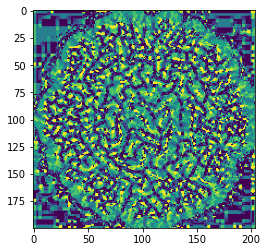

In [5]:
n_pts = 8
radius = 3
lbp_im = ski.feature.local_binary_pattern(im, n_pts, radius, 'uniform')

fig,ax = plt.subplots(1)
colormap = plt.get_cmap('viridis_r', n_pts)
ax.imshow(lbp_im, cmap=colormap, vmin=0, vmax=n_pts + 1)

We can look at a histogram instead. The histogram defines the space where we look for smooth trajectories.

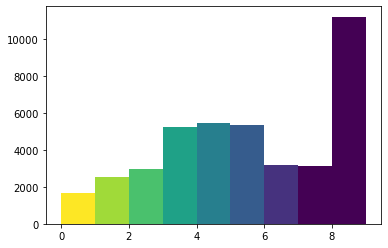

In [6]:
fig,ax = plt.subplots(1)
counts, bins, patches = ax.hist(lbp_im.flatten(), bins=n_pts+1)
for i,p in enumerate(patches):
    p.set_facecolor(colormap(i))

# Smooth trajectories in feature space

*CoordinatesTable.csv* contains the principal components of each image. We can show the smooth trajectories of the yeast colonies in this feature space.

In [7]:
coordinatesTable = pd.read_csv(coordinatesTablePath, index_col=0)
coordinatesTable.head()

,Folder,Filename,Time,PCA_1,PCA_2,PCA_3
0,2014-10-23-Cam1,YPG11407_001_0.jpg,0,-0.523153,0.235259,0.293905
1,2014-10-23-Cam1,YPG11407_001_1002.jpg,1002,-0.069516,0.503079,0.347527
2,2014-10-23-Cam1,YPG11407_001_1028.jpg,1028,-0.072080,0.486843,0.354248
3,2014-10-23-Cam1,YPG11407_001_1054.jpg,1054,-0.062752,0.481654,0.370832
4,2014-10-23-Cam1,YPG11407_001_1080.jpg,1080,-0.077481,0.472005,0.372762


In [8]:
def get_trajectory(rootName):
    selection = [rootName in fullName for fullName in coordinatesTable.Filename]
    unsorted = coordinatesTable[selection][['Time', 'PCA_1', 'PCA_2', 'PCA_3']].to_numpy()
    return np.sort(unsorted, axis=0)

In [9]:
# Two prototypes from cut_height = 0.55 (see below)
name1 = 'YPG11414_005'
name2 = 'YPG11602_08'
data1 = get_trajectory(name1)
data2 = get_trajectory(name2)

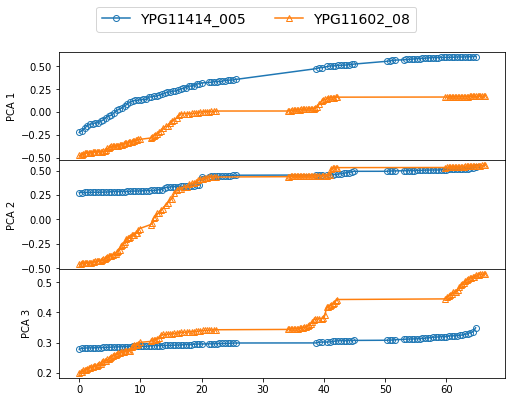

In [10]:
fig,axes = plt.subplots(3, 1, figsize=[8,6])
fig.subplots_adjust(hspace=0)
for i in range(3):
    ax = axes[i]
    ax.plot(data1[:, 0]/60, data1[:, 1 + i], marker='o', markerfacecolor='None')
    ax.plot(data2[:, 0]/60, data2[:, 1 + i], marker='^', markerfacecolor='None')
    ax.set_ylabel('PCA {}'.format(1 + i))
fig.legend([name1,name2], ncol=2, loc='upper center', fontsize=14)

# Hierarchical clustering

*DistancesTable.csv* contains all the information we need to construct the distance matrix between the yeast colonies.

In [11]:
distancesTable = pd.read_csv(distancesTablePath, index_col=0)
distancesTable.head()

/Users/andy/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,I,J,I Root Filename,J Root Filename,Distance
0,0,1,YPG11407_001,YPG11407_002,0.073990
1,0,2,YPG11407_001,YPG11407_003,0.083862
2,0,3,YPG11407_001,YPG11407_004,0.090739
3,0,4,YPG11407_001,YPG11407_005,0.077241
4,0,5,YPG11407_001,YPG11407_006,0.116214


Construct the distance matrix using *scipy*.

In [12]:
X = sp.spatial.distance.squareform(distancesTable['Distance'].to_numpy())

Any clustering algorithm can be applied directly to this distance matrix. For `pyprotoclust.protoclust`, the output is a pair `(Z, prototypes)`. The first entry `Z` is an encoding of the clustering as a linkage matrix for use with the *scipy.hierarchy* library. The second entry `prototypes` lists the index of the associated prototypes for each level in the linkage matrix.

In [13]:
Z, prototypes = protoclust(X, verbose=True, notebook=True)

  0%|          | 0/5498 [00:00<?, ?it/s]

We can use the linkage matrix with the default methods in *scipy.hierarchy*. We can cut the dendrogram assocaited with our linkage matrix `Z`. The leaders `L` of the exposed root nodes are the best representatives of the data at the distance set by `cut_height`.

In [14]:
cut_height = 0.55
T = sp.cluster.hierarchy.fcluster(Z, cut_height, criterion='distance')
L, _ = sp.cluster.hierarchy.leaders(Z, T)

We can get the list of the unique colony names in the *DistancesTable.csv*, noting that the columns are ordered. We'll use this to identify who our prototypes are. We could now go back to figshare and download *ImageData/ProcessedYeastImages.zip* to find image files associated with the prototype we uncovered here.

In [15]:
names = distancesTable['I Root Filename'].unique()
names[[prototypes[l] for l in L]]

array(['YPG11640_35', 'YPG11538_11', 'YPG11414_005', 'YPG11602_08'],
      dtype=object)